In [1]:
import collections
import csv
import functools
import gzip
import json
import math
import pathlib

import networkx as nx
import numpy as np

import util

In [2]:
RESOURCES_DIR = pathlib.Path('../resources')

In [3]:
with open(RESOURCES_DIR / 'hierarchy_raw/audioset/ontology.json') as f:
    ontology = json.load(f)

In [4]:
len(ontology)

632

In [5]:
# Build index by name.
node_to_cat = {x['id']: x for x in ontology}

In [6]:
g = nx.DiGraph()
for x in ontology:
    node = x['id']
    for child in x['child_ids']:
        g.add_edge(node, child)

In [7]:
tag_to_name = {tag: node_to_cat[tag]['name'] for tag in g}

In [8]:
top_nodes = [x for x in g if g.in_degree(x) == 0]
[tag_to_name[x] for x in top_nodes]

['Human sounds',
 'Animal',
 'Music',
 'Natural sounds',
 'Sounds of things',
 'Source-ambiguous sounds',
 'Channel, environment and background']

In [9]:
# Add root node.
for x in top_nodes:
    g.add_edge('root', x)
tag_to_name['root'] = 'Audio'

[x for x in g if g.in_degree(x) == 0]

['root']

In [10]:
len(g)

633

In [11]:
leaf_nodes = [x for x in g if g.out_degree[x] == 0]
len(leaf_nodes)

474

In [12]:
# Check for nodes with multiple parents.
sum(1 for x in g if g.in_degree[x] > 1)

38

In [13]:
for node in g:
    parents = list(g.predecessors(node))
    if len(parents) > 1:
        print('{!r} has multiple parents: {!r}'.format(
            tag_to_name[node],
            [tag_to_name[p] for p in parents]))

'Children shouting' has multiple parents: ['Shout', 'Human group actions']
'Choir' has multiple parents: ['Singing', 'Musical instrument']
'Chant' has multiple parents: ['Singing', 'Vocal music']
'Clapping' has multiple parents: ['Hands', 'Human group actions']
'Hubbub, speech noise, speech babble' has multiple parents: ['Human group actions', 'Noise']
'Howl' has multiple parents: ['Dog', 'Canidae, dogs, wolves']
'Growling' has multiple parents: ['Dog', 'Cat', 'Roaring cats (lions, tigers)', 'Canidae, dogs, wolves']
'Hiss' has multiple parents: ['Cat', 'Snake', 'Steam', 'Onomatopoeia']
'Clip-clop' has multiple parents: ['Horse', 'Clicking']
'Cowbell' has multiple parents: ['Cattle, bovinae', 'Percussion', 'Bell']
'Bleat' has multiple parents: ['Goat', 'Sheep']
'Chirp, tweet' has multiple parents: ['Bird vocalization, bird call, bird song', 'Brief tone']
'Buzz' has multiple parents: ['Fly, housefly', 'Bee, wasp, etc.', 'Brief tone']
'Rattle' has multiple parents: ['Snake', 'Onomatopoeia

In [14]:
# Load label set from file.
with open(RESOURCES_DIR / 'hierarchy_raw/audioset/class_labels_indices.csv') as f:
    reader = csv.reader(f)
    header_row = next(reader)
    rows = list(csv.reader(f))

label_tags = [row[1] for row in rows]

In [15]:
# Check whether blacklist nodes are present amongst label set.
[(tag, tag_to_name[tag]) for tag in label_tags if 'blacklist' in node_to_cat[tag]['restrictions']]

[('/m/01jg1z', 'Heart murmur'),
 ('/m/07r4gkf', 'Patter'),
 ('/m/074ft', 'Song'),
 ('/m/01h82_', 'Engine knocking'),
 ('/m/02z32qm', 'Fusillade'),
 ('/m/0b_fwt', 'Electronic tuner'),
 ('/m/07s8j8t', 'Roll'),
 ('/m/07qmpdm', 'Clatter'),
 ('/m/0b9m1', 'Harmonic'),
 ('/m/08p9q4', 'Sidetone'),
 ('/m/01jwx6', 'Vibration'),
 ('/m/07hvw1', 'Field recording')]

In [16]:
def take_subgraph(g, nodes):
    h = nx.DiGraph()

    def add_ancestors(x):
        for p in g.predecessors(x):
            h.add_edge(p, x)
            add_ancestors(p)

    for x in nodes:
        add_ancestors(x)
    return h

In [17]:
g = take_subgraph(g, label_tags)
len(g)

558

In [18]:
def find_required(g):

    @functools.lru_cache
    def required(x):
        children = list(g.successors(x))
        if len(children) == 0:
            return True
        return any(required(c) and g.in_degree[c] == 1 for c in children)
    
    return {x: required(x) for x in g}

In [19]:
required = find_required(g)
len(required)

558

In [20]:
all(required)

True

In [21]:
leaf_nodes = set(x for x in g if g.out_degree[x] == 0)
len(leaf_nodes)

408

In [22]:
# Check for nodes with multiple parents.
sum(1 for x in g if g.in_degree[x] > 1)

36

In [23]:
for node in g:
    parents = list(g.predecessors(node))
    if len(parents) > 1:
        print('{!r} has multiple parents: {!r}'.format(
            tag_to_name[node],
            [tag_to_name[p] for p in parents]))

'Children shouting' has multiple parents: ['Shout', 'Human group actions']
'Choir' has multiple parents: ['Singing', 'Musical instrument']
'Chant' has multiple parents: ['Singing', 'Vocal music']
'Clapping' has multiple parents: ['Hands', 'Human group actions']
'Hubbub, speech noise, speech babble' has multiple parents: ['Human group actions', 'Noise']
'Howl' has multiple parents: ['Dog', 'Canidae, dogs, wolves']
'Growling' has multiple parents: ['Dog', 'Cat', 'Roaring cats (lions, tigers)', 'Canidae, dogs, wolves']
'Hiss' has multiple parents: ['Cat', 'Snake', 'Steam', 'Onomatopoeia']
'Clip-clop' has multiple parents: ['Horse', 'Clicking']
'Cowbell' has multiple parents: ['Cattle, bovinae', 'Percussion', 'Bell']
'Bell' has multiple parents: ['Musical instrument', 'Sounds of things']
'Bleat' has multiple parents: ['Goat', 'Sheep']
'Chirp, tweet' has multiple parents: ['Bird vocalization, bird call, bird song', 'Brief tone']
'Buzz' has multiple parents: ['Fly, housefly', 'Bee, wasp, etc

In [24]:
for node in g:
    parents = list(g.predecessors(node))
    if len(parents) > 1:
        lca = functools.reduce(
            functools.partial(nx.lowest_common_ancestor, g),
            parents)
        print('{!r} <- {!r} <- ... <- {!r}'.format(
              tag_to_name[node],
              [tag_to_name[p] for p in parents],
              tag_to_name[lca]))

'Children shouting' <- ['Shout', 'Human group actions'] <- ... <- 'Human sounds'
'Choir' <- ['Singing', 'Musical instrument'] <- ... <- 'Audio'
'Chant' <- ['Singing', 'Vocal music'] <- ... <- 'Audio'
'Clapping' <- ['Hands', 'Human group actions'] <- ... <- 'Human sounds'
'Hubbub, speech noise, speech babble' <- ['Human group actions', 'Noise'] <- ... <- 'Audio'
'Howl' <- ['Dog', 'Canidae, dogs, wolves'] <- ... <- 'Animal'
'Growling' <- ['Dog', 'Cat', 'Roaring cats (lions, tigers)', 'Canidae, dogs, wolves'] <- ... <- 'Animal'
'Hiss' <- ['Cat', 'Snake', 'Steam', 'Onomatopoeia'] <- ... <- 'Audio'
'Clip-clop' <- ['Horse', 'Clicking'] <- ... <- 'Audio'
'Cowbell' <- ['Cattle, bovinae', 'Percussion', 'Bell'] <- ... <- 'Audio'
'Bell' <- ['Musical instrument', 'Sounds of things'] <- ... <- 'Audio'
'Bleat' <- ['Goat', 'Sheep'] <- ... <- 'Livestock, farm animals, working animals'
'Chirp, tweet' <- ['Bird vocalization, bird call, bird song', 'Brief tone'] <- ... <- 'Audio'
'Buzz' <- ['Fly, housefl

In [25]:
leaf_descendants = {x: set(nx.descendants(g, x)).union({x}).intersection(leaf_nodes) for x in g}
num_leaf_descendants = {k: len(v) for k, v in leaf_descendants.items()}

In [26]:
min(num_leaf_descendants.values()), max(num_leaf_descendants.values())

(1, 408)

In [27]:
information = {x: math.log(len(leaf_nodes)) - math.log(num_leaf_descendants[x]) for x in g}

In [28]:
for node in g:
    parents = list(g.predecessors(node))
    if len(parents) > 1:
        lca = functools.reduce(
            functools.partial(nx.lowest_common_ancestor, g),
            parents)
        print('{!r} <- {!r} <- ... <- {!r}'.format(
              tag_to_name[node],
              [(tag_to_name[p], round(information[p], 2)) for p in parents],
              tag_to_name[lca]))

'Children shouting' <- [('Shout', 4.4), ('Human group actions', 3.93)] <- ... <- 'Human sounds'
'Choir' <- [('Singing', 3.93), ('Musical instrument', 1.92)] <- ... <- 'Audio'
'Chant' <- [('Singing', 3.93), ('Vocal music', 4.91)] <- ... <- 'Audio'
'Clapping' <- [('Hands', 5.32), ('Human group actions', 3.93)] <- ... <- 'Human sounds'
'Hubbub, speech noise, speech babble' <- [('Human group actions', 3.93), ('Noise', 3.61)] <- ... <- 'Audio'
'Howl' <- [('Dog', 4.22), ('Canidae, dogs, wolves', 5.32)] <- ... <- 'Animal'
'Growling' <- [('Dog', 4.22), ('Cat', 4.4), ('Roaring cats (lions, tigers)', 5.32), ('Canidae, dogs, wolves', 5.32)] <- ... <- 'Animal'
'Hiss' <- [('Cat', 4.4), ('Snake', 5.32), ('Steam', 6.01), ('Onomatopoeia', 2.64)] <- ... <- 'Audio'
'Clip-clop' <- [('Horse', 5.32), ('Clicking', 4.91)] <- ... <- 'Audio'
'Cowbell' <- [('Cattle, bovinae', 5.32), ('Percussion', 3.18), ('Bell', 4.07)] <- ... <- 'Audio'
'Bell' <- [('Musical instrument', 1.92), ('Sounds of things', 1.11)] <- ..

In [29]:
subg = take_subgraph(g, [x for x in g if g.in_degree[x] > 1])
len(subg)

106

In [30]:
from matplotlib import pyplot as plt

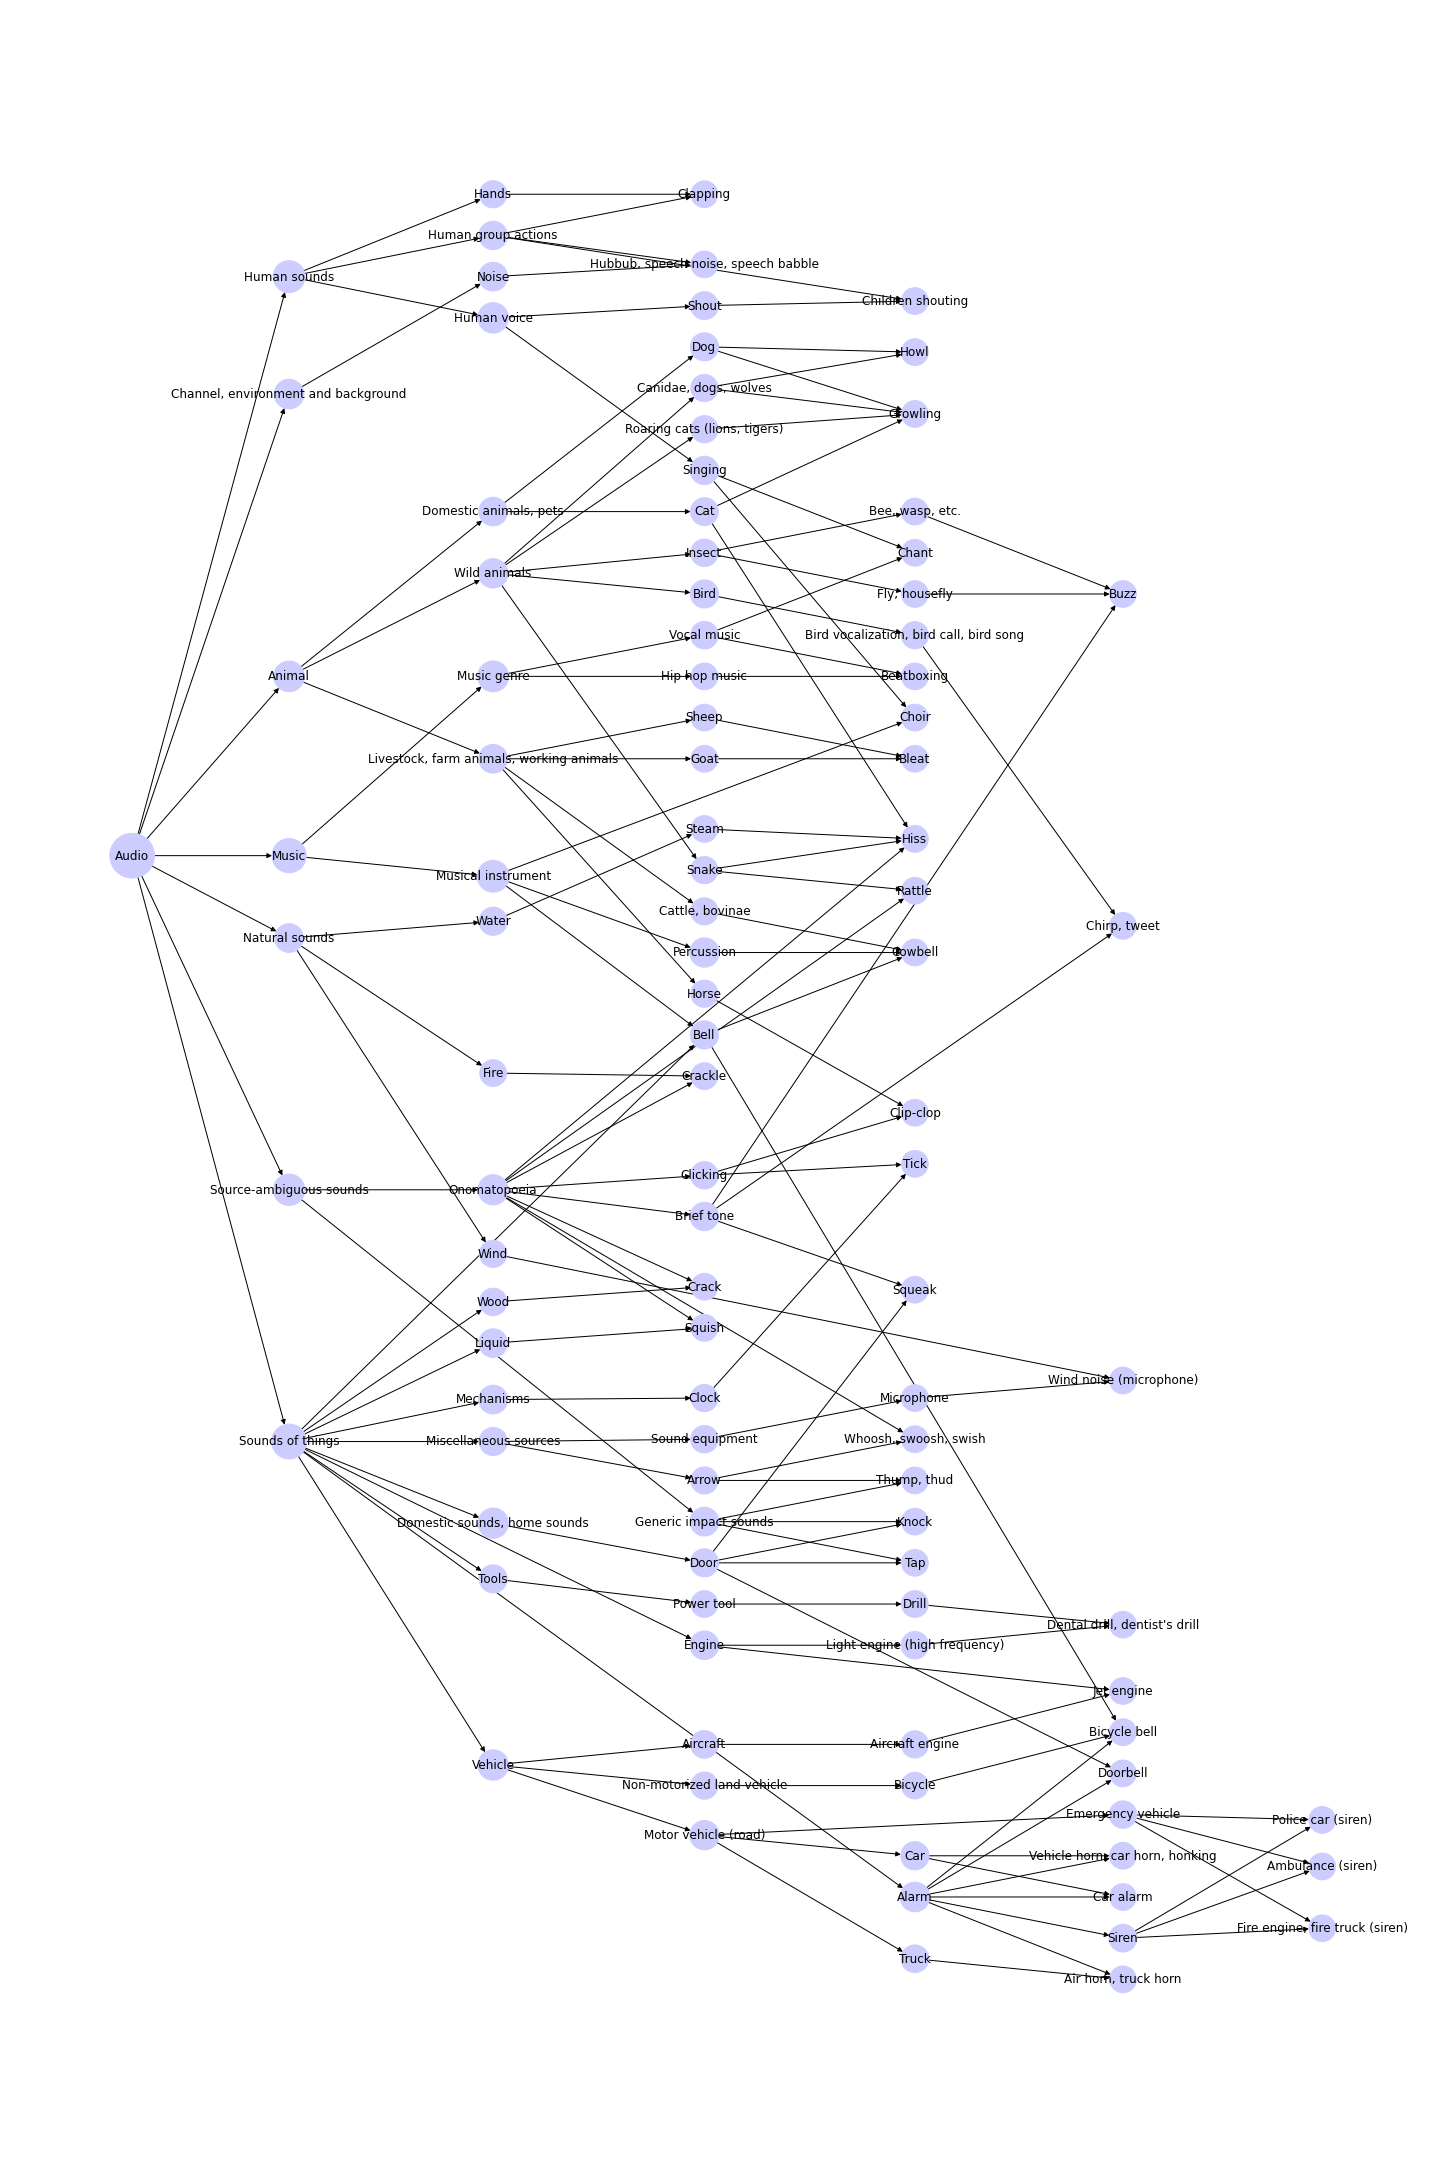

In [31]:
subg.graph['graph'] = dict(rankdir='LR')
pos = nx.nx_pydot.graphviz_layout(subg, prog='dot')
plt.figure(figsize=[20, 30])
nx.draw(
    subg, pos,
    node_color='#ccccff',
    with_labels=True,
    labels={k: tag_to_name[k] for k in subg},
    nodelist=list(subg),
    node_size=[500 + 1500 / (1 + information[x]) for x in subg])

In [32]:
# Check which labels have multiple paths from root to node.

def find_num_paths(g):
    @functools.lru_cache
    def num_paths(x):
        parents = list(g.predecessors(x))
        if not parents:
            return 1
        return sum(num_paths(parent) for parent in parents)
    return {x: num_paths(x) for x in g}

num_paths = find_num_paths(g)
assert all(x >= 1 for x in num_paths.values())

In [33]:
# What fraction of labels have multiple paths?
sum(1 for x in label_tags if num_paths[x] > 1), len(label_tags)

(46, 527)

In [34]:
# What's the distribution of number of paths?
collections.Counter(num_paths[tag] for tag in label_tags).items()

dict_items([(1, 481), (2, 41), (4, 4), (3, 1)])

In [35]:
{tag_to_name[tag]: num_paths[tag] for tag in label_tags if num_paths[tag] >= 3}

{'Growling': 4, 'Hiss': 4, 'Cowbell': 4, 'Buzz': 3, 'Bicycle bell': 4}

In [36]:
{tag_to_name[tag]: num_paths[tag] for tag in label_tags if num_paths[tag] == 2}

{'Children shouting': 2,
 'Choir': 2,
 'Chant': 2,
 'Mantra': 2,
 'Clapping': 2,
 'Hubbub, speech noise, speech babble': 2,
 'Howl': 2,
 'Clip-clop': 2,
 'Bleat': 2,
 'Chirp, tweet': 2,
 'Rattle': 2,
 'Bell': 2,
 'Church bell': 2,
 'Jingle bell': 2,
 'Tuning fork': 2,
 'Chime': 2,
 'Wind chime': 2,
 'Change ringing (campanology)': 2,
 'Beatboxing': 2,
 'Wind noise (microphone)': 2,
 'Crackle': 2,
 'Vehicle horn, car horn, honking': 2,
 'Toot': 2,
 'Car alarm': 2,
 'Air horn, truck horn': 2,
 'Police car (siren)': 2,
 'Ambulance (siren)': 2,
 'Fire engine, fire truck (siren)': 2,
 'Jet engine': 2,
 "Dental drill, dentist's drill": 2,
 'Doorbell': 2,
 'Ding-dong': 2,
 'Knock': 2,
 'Tap': 2,
 'Squeak': 2,
 'Tick': 2,
 'Crack': 2,
 'Squish': 2,
 'Whoosh, swoosh, swish': 2,
 'Thump, thud': 2,
 'Thunk': 2}

In [37]:
tree_labels = [x for x in label_tags if num_paths[x] == 1]
len(tree_labels)

481

In [38]:
tree = take_subgraph(g, tree_labels)
len(tree)

511

In [39]:
edges = util.dfs_edges_with_order(tree, tree_labels)
with open(RESOURCES_DIR / 'hierarchy/audioset_tree.csv', 'w') as f:
    w = csv.writer(f)
    for edge in edges:
        w.writerow(edge)

In [40]:
# Remove trivial nodes (1 child).
tree_nontrivial = util.remove_trivial(tree, root='root')
len(tree_nontrivial)

469

In [41]:
# edges = util.dfs_edges_with_order(tree_nontrivial, tree_labels)
# with open(RESOURCES_DIR / 'hierarchy/audioset_tree_nontrivial.csv', 'w') as f:
#     w = csv.writer(f)
#     for edge in edges:
#         w.writerow(edge)

In [42]:
import tensorflow as tf

In [43]:
data_dir = pathlib.Path('~/data/manual/audioset/audioset_v1_embeddings').expanduser()

def get_labels(record):
    return tf.train.SequenceExample.FromString(record.numpy()).context.feature['labels'].int64_list.value

split_dir = data_dir / 'unbal_train/'
tfrecord_files = list(map(str, split_dir.iterdir()))

In [44]:
dataset = tf.data.TFRecordDataset(tfrecord_files)
labels = list(map(get_labels, dataset))
del dataset

2022-03-15 15:11:57.953221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-15 15:11:57.953239: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [45]:
example_tags = [list(map(label_tags.__getitem__, x)) for x in labels]

In [46]:
# What fraction of examples contains only labels with 1 path?
sum(1 for tags in example_tags if all(num_paths[tag] == 1 for tag in tags)), len(example_tags)

(1974513, 2041789)

In [47]:
# What fraction of examples has a single label?
sum(1 for tags in example_tags if len(tags) == 1), len(example_tags)

(890547, 2041789)

In [48]:
# What fraction of examples has a single label that has 1 path?
sum(1 for tags in example_tags if len(tags) == 1 and num_paths[tags[0]] == 1), len(example_tags)

(877103, 2041789)

In [49]:
ancestors = {x: nx.ancestors(g, x) for x in g}

def remove_ancestors(nodes):
    return [u for u in nodes if not any(u in ancestors[v] for v in nodes)]

In [50]:
without_ancestors = list(map(remove_ancestors, example_tags))

In [51]:
np.mean(list(map(len, example_tags)))

1.9689654513762196

In [52]:
np.mean(list(map(len, without_ancestors)))

1.499420361261619

In [53]:
# What fraction of examples contains one label (plus ancestors of that label)?
sum(1 for tags in without_ancestors if len(tags) == 1), len(example_tags)

(1216550, 2041789)

In [54]:
# And if we further exclude example with multiple paths?
sum(1 for tags in without_ancestors if len(tags) == 1 and num_paths[tags[0]] == 1), len(example_tags)

(1184833, 2041789)

In [55]:
# Write labels to file with empty string for excluded examples.
final_labels = [
    tags[0] if len(tags) == 1 and num_paths[tags[0]] == 1 else ''
    for tags in without_ancestors
]

In [56]:
with gzip.open(RESOURCES_DIR / 'override_labels/audioset-train-singular-tree.txt.gz', 'wt') as f:
    f.writelines([x + '\n' for x in final_labels])